### Mod 1 Project --- Data Movie

In [1]:
#top 50 lucrative movies from  tn_movie_budgets and bom_movie_gross   (find their ratings)
# most (top50) popular movies from tmdb_movies
# highest(top 50) ratings from imdb_title_ratings

# select common movies from above list
#find their genre, directors

### Import libraries & database

In [2]:
#!pip install mysql-connector-python
#!pip install fuzzywuzzy
#!pip install python-Levenshtein

In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import string
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
%matplotlib inline

In [2]:
con = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')
cur = con.cursor()

# Data Cleaning

### IMDB Titles

In [3]:
query = ('''
SELECT *
FROM imdb_title_basics imdb_b
JOIN imdb_title_crew imdb_c USING (tconst)
JOIN imdb_title_ratings imdb_e USING (tconst)
''')
imdb_titles = pd.read_sql_query(query, con)
#joining all IMDB title tables using title ids and name ids

In [4]:
imdb_titles.isna().sum()
#checking for null values

tconst                 0
primary_title          0
original_title         0
start_year             0
runtime_minutes     7620
genres                 0
directors              0
writers            10561
averagerating          0
numvotes               0
dtype: int64

In [5]:
imdb_titles = imdb_titles.dropna(subset=['runtime_minutes'])
imdb_titles = imdb_titles.dropna(subset=['writers'])
#Removing rows with null values for runtime minutes and writers

In [6]:
pd.set_option('display.max_columns',None)
# Want to see all columns to see which are going to be useful

In [7]:
imdb_titles['genres'] = imdb_titles['genres'].map(lambda x: x.split(','))
imdb_titles['directors'] = imdb_titles['directors'].map(lambda x: x.split(','))
imdb_titles['writers'] = imdb_titles['writers'].map(lambda x: x.split(','))
# Converting genres, directors, writers to lists, so we can easily check most popular later.

In [8]:
imdb_titles['age_of_movie']= 2020 - imdb_titles['start_year']
#Creating new column to have "age of movie" as a reference

In [9]:
#this line of code doesnt drop the number in the moviee name
# imdb_titles['dummy_title'] = imdb_titles['primary_title'].str.replace('[^\w\s\d]','')

translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
imdb_titles['dummy_title'] = imdb_titles.primary_title.map(lambda x: x.translate(translator1).translate(translator2).strip())


imdb_titles['dummy_title'] = imdb_titles['dummy_title'].str.replace('[ ]','_')
imdb_titles['dummy_title'] = imdb_titles['dummy_title'].str.lower()
imdb_titles['dummy_title'] = imdb_titles['dummy_title'].map(lambda x: x.strip())
#Creating a dummy_title column, to be used for our dummy_key

In [10]:
imdb_titles['start_year'] = imdb_titles['start_year'].map(lambda x: str(x))
#Turning start_year to string so that I can combine it with dummy_title in another column

In [11]:
imdb_titles['dummy_key'] = imdb_titles['dummy_title'] + "_" + imdb_titles['start_year']
#Creating a new column for dummy_key

In [12]:
imdb_titles = imdb_titles.drop(columns=['dummy_title'])
#removing dummy_title since I have the dummy_key I need

### IMDB Crew

In [13]:
query = ('''
SELECT *
FROM imdb_name_basics
''')
imdb_crew = pd.read_sql_query(query, con)

In [14]:
imdb_crew.isna().sum()
# Checking for null values

nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession         0
known_for_titles           0
dtype: int64

In [15]:
imdb_crew = imdb_crew.fillna(0)
#Replacing null values with 0

In [16]:
imdb_crew['birth_year'] = imdb_crew['birth_year'].map(lambda x: int(x))
imdb_crew['death_year'] = imdb_crew['death_year'].map(lambda x: int(x))
#Converting birth years and death years to integer

In [17]:
imdb_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
nconst                606648 non-null object
primary_name          606648 non-null object
birth_year            606648 non-null int64
death_year            606648 non-null int64
primary_profession    606648 non-null object
known_for_titles      606648 non-null object
dtypes: int64(2), object(4)
memory usage: 27.8+ MB


In [18]:
imdb_crew['primary_profession'] = imdb_crew['primary_profession'].map(lambda x: x.split(','))
imdb_crew['known_for_titles'] = imdb_crew['known_for_titles'].map(lambda x: x.split(','))
#Converting these to lists so we can easily reference them later

In [19]:
imdb_crew['age'] = imdb_crew.apply(lambda row: (2020 - row['birth_year']) if row['death_year'] == 0 else None, axis=1)
#Adding an age column. If the age is 2020, it means that there is no birth year available. If the age is equal to None, it means the person is dead.

### BOM

In [20]:
query = ('''
SELECT * FROM bom_movie_gross
''')
bom = pd.read_sql_query(query, con)

In [21]:
#drop Null value in domestic_gross
bom = bom.dropna(subset =['domestic_gross'])

#convert Null value in foreign_gross to 0
bom.foreign_gross = bom.foreign_gross.fillna(0)

#convert domestic_gross and foreign_gross from float to int
bom.domestic_gross = bom.domestic_gross.map(lambda x: int(x))   
bom.foreign_gross = bom.foreign_gross.map(lambda x: int(x))  

In [22]:
#remove spaces on both end of strings
bom.title = bom.title.map(lambda x: x.strip())
bom.studio = bom.studio.map(lambda x: x.strip())

In [23]:
#convert year to str
bom['year'] = bom['year'].map(str)

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
bom['title_cleaned'] = bom.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
bom['title_cleaned'] = bom['title_cleaned'] + '_' + bom['year']

#replace all empty spaces with _ and lower all string
bom['title_cleaned'] = bom['title_cleaned'].str.replace(' ','_').str.lower()

#convert year back to int
bom['year'] = bom['year'].map(int)

### TN

In [24]:
query_tn = ('''
SELECT * FROM tn_movie_budgets
''')
tn = pd.read_sql_query(query_tn, con)

In [25]:
# convert release_date to date format
tn.release_date = tn.release_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y'))

# convert production_budget, domestic_gross, worldwide_gross to date format
tn.production_budget = tn.production_budget.map(lambda x: int(x.replace(',','').replace('$','')))
tn.domestic_gross = tn.domestic_gross.map(lambda x: int(x.replace(',','').replace('$','')))
tn.worldwide_gross = tn.worldwide_gross.map(lambda x: int(x.replace(',','').replace('$','')))

#add profit column
tn['profit'] = tn.worldwide_gross - tn.production_budget

In [26]:
#add new column for release year
tn['year'] = tn.release_date.map(lambda x: str(x.year))

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
tn['title_cleaned'] = tn.movie.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
tn['title_cleaned'] = tn['title_cleaned']+'_'+tn['year']

#replace all empty spaces with _ and lower all string
tn['title_cleaned'] = tn['title_cleaned'].str.replace(' ','_').str.lower()

#drop column year
tn = tn.drop(axis = 1, columns='year')

### TMDB

In [27]:
query_tmdb = ('''
SELECT * FROM tmdb_movies
''')
tmdb = pd.read_sql_query(query_tmdb, con)

In [28]:
query_tmdb_link = ('''
SELECT * FROM tmdb_imdb_link
''')
tmdb_link = pd.read_sql_query(query_tmdb_link, con)

In [29]:
#convert genre_ids to int
tmdb.genre_ids.map(lambda x: int(x))

#remove spaces on both end of strings
tmdb.original_language = tmdb.original_language.map(lambda x: x.strip())
tmdb.original_title = tmdb.original_title.map(lambda x: x.strip())
tmdb.title = tmdb.title.map(lambda x: x.strip())

In [30]:
#Join tmdb and tmdb_link tables
tmdb = tmdb.join(tmdb_link.set_index('tmdb_id'), on = 'id', how = 'left')

In [31]:
#clean the joined table
tmdb.imdb_id = tmdb.imdb_id.fillna(0).map(lambda x: int(x))

In [32]:
#add new column for release year
tmdb['year'] = tmdb.release_date.map(lambda x: str(x.year))

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
tmdb['title_cleaned'] = tmdb.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
tmdb['title_cleaned'] = tmdb['title_cleaned']+'_'+tmdb['year']

#replace all empty spaces with _ and lower all string
tmdb['title_cleaned'] = tmdb['title_cleaned'].str.replace(' ','_').str.lower()

#drop column year
tmdb = tmdb.drop(axis = 1, columns='year')

### RT

In [33]:
query_rt_info = ('''
SELECT * FROM rt_movie_info
''')
rt_info = pd.read_sql_query(query_rt_info, con)

In [34]:
query_rt_reviews = ('''
SELECT * FROM rt_reviews
''')
rt_reviews = pd.read_sql_query(query_rt_reviews, con)

In [35]:
query_rt_link = ('''
SELECT * FROM rt_imdb_link
''')
rt_link = pd.read_sql_query(query_rt_link, con)

### RT_Info Cleaning

In [36]:
#replace empty value in theater_date and dvd_date with Jan 1,1000
rt_info['theater_date'].loc[rt_info.theater_date == ''] = 'Jan 1, 1000'
rt_info['dvd_date'].loc[rt_info.dvd_date == ''] = 'Jan 1, 1000'

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [37]:
#convert theater_date and dvd_date to datetime format
rt_info.theater_date = rt_info.theater_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y').date())
rt_info.dvd_date = rt_info.dvd_date.map(lambda x: dt.datetime.strptime(x, '%b %d, %Y').date())

In [38]:
#clean box_office date
rt_info['box_office'].loc[rt_info.box_office == ''] = '0'
rt_info['box_office'] = rt_info.box_office.map(lambda x: int(x.replace(',', '')))

In [39]:
#clean runtime (replace empty value with 0)
rt_info['runtime'].loc[rt_info.runtime == ''] = '0'
rt_info['runtime'] = rt_info.runtime.map(lambda x: int(x.replace('minutes', '')))

In [40]:
#remove spaces on both end of strings
rt_info.synopsis = rt_info.synopsis.map(lambda x: x.strip())
rt_info.rating = rt_info.rating.map(lambda x: x.strip())
rt_info.genre = rt_info.genre.map(lambda x: x.strip())
rt_info.director = rt_info.director.map(lambda x: x.strip())
rt_info.writer = rt_info.writer.map(lambda x: x.strip())

In [41]:
rt_info['genre'] = rt_info['genre'].map(lambda x: x.split('|'))
rt_info['writer'] = rt_info['writer'].map(lambda x: x.split('|'))
rt_info['director'] = rt_info['director'].map(lambda x: x.split('|'))
#Converting genre, writer, director to list so we can reference them easily

In [42]:
rt_info = rt_info.drop(columns=['box_office','currency'],axis=1)
#Dropping box_office because we have better data on another table, dropping currency because we removed box office data

### RT_Reviews Cleaning

In [43]:
#convert date to datetime format
rt_reviews.date = rt_reviews.date.map(lambda x: dt.datetime.strptime(x, '%B %d, %Y').date())

In [44]:
#convert top_critic to int
rt_reviews.top_critic = rt_reviews.top_critic.map(lambda x: int(x))

In [45]:
#remove spaces on both end of strings
rt_reviews.review = rt_reviews.review.map(lambda x: x.strip())
rt_reviews.rating = rt_reviews.rating.map(lambda x: x.strip())
rt_reviews.fresh = rt_reviews.fresh.map(lambda x: x.strip())
rt_reviews.critic = rt_reviews.critic.map(lambda x: x.strip())
rt_reviews.publisher = rt_reviews.publisher.map(lambda x: x.strip())

### RT_link cleaning

In [46]:
rt_link.year = rt_link.year.fillna(1000)

In [47]:
rt_link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17468 entries, 0 to 17467
Data columns (total 6 columns):
imdbid         17468 non-null int64
rtid           17468 non-null int64
title          17468 non-null object
year           17468 non-null float64
mpaa_rating    17468 non-null object
runtime        17468 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 818.9+ KB


In [48]:
#replace empty space to year 1000 in year
rt_link.year = rt_link.year.fillna(1000)

#convert date to datetime format
rt_link.year = rt_link.year.map(lambda x: (int(x)))

In [49]:
#replace empty space in runtime to 0
rt_link['runtime'].loc[rt_link.runtime == ''] = '0'

#convert runtime to int format
rt_link.runtime = rt_link.runtime.map(lambda x: (int(x)))

In [50]:
#convert year to str
rt_link['year'] = rt_link['year'].map(str)

#remove all punctuation and numbers inside movie title
translator1 = str.maketrans('0123456789','..........')
translator2 = str.maketrans('', '', string.punctuation)
rt_link['title_cleaned'] = rt_link.title.map(lambda x: x.translate(translator1).translate(translator2).strip())

#combine title and year
rt_link['title_cleaned'] = rt_link['title_cleaned'] + '_' + rt_link['year']

#replace all empty spaces with _ and lower all string
rt_link['title_cleaned'] = rt_link['title_cleaned'].str.replace(' ','_').str.lower()

#convert year back to int
rt_link['year'] = rt_link['year'].map(int)

# Top 200 Profitable Movies after 2000

### Both BOM and TN have similar information about budget, but TN database is more complete so we decided to use TN to calculate profit.

In [184]:
# add ROI column to TN table (ROI = profit/production_budget)
tn['roi'] = tn.profit/tn.production_budget

In [185]:
# get top 200 revenue domestic movies after 2000
top200_revenue_domestic = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('domestic_gross',ascending=False).head(200)

# get top 200 revenue worldwide movies after 2000
top200_revenue_world = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('worldwide_gross',ascending=False).head(200)

# get top 200 profit movies after 2000
top200_profit = tn.loc[tn.release_date>dt.datetime(2000,1,1)].sort_values('profit',ascending=False).head(200)

#get top 200 ROI movies with worldwide_gross higher than 100 million
top200_roi = tn.loc[(tn.release_date>dt.datetime(2000,1,1)) & (tn.worldwide_gross>100000000)].sort_values('roi',ascending=False).head(200)


Combine table for top profit

In [186]:
# there are only 140 movies from top200_profit that can be find inside imdb datebdase. 
# So we narrowed our data to these 123 movies

top123_profit_imdb = imdb_titles.loc[imdb_titles.dummy_key.isin(list(top200_profit.title_cleaned))]

# drop original title
top123_profit_imdb = top123_profit_imdb.drop(axis = 1, columns = 'original_title')

#join tn and imdb database together for top 123 movies
top123_profit = top123_profit_imdb.merge(
    top200_profit, left_on='dummy_key', right_on ='title_cleaned').drop(
    axis=1, columns=['start_year', 'id', 'movie', 'title_cleaned'])

combine table for top ROI

In [187]:
# there are only 103 movies from top200_roi that can be find inside imdb datebdase. 
# So we narrowed our data to these 103 movies

top103_roi_imdb = imdb_titles.loc[imdb_titles.dummy_key.isin(list(top200_roi.title_cleaned))]

# drop original title
top103_roi_imdb = top103_roi_imdb.drop(axis = 1, columns = 'original_title')

#join tn and imdb database together for top 103 movies
top103_roi = top103_roi_imdb.merge(
    top200_profit, left_on='dummy_key', right_on ='title_cleaned').drop(
    axis=1, columns=['start_year', 'id', 'movie', 'title_cleaned'])

### Plot top 20 most profitable movies

In [188]:
top200_profit.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,title_cleaned,ROI,roi
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,avatar_2009,5.532577,5.532577
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,1748134200,avengers_infinity_war_2018,5.827114,5.827114
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220,star_wars_ep_vii_the_force_awakens_2015,5.710167,5.710167
33,34,2015-06-12,Jurassic World,215000000,652270625,1648854864,1433854864,jurassic_world_2015,6.669092,6.669092
66,67,2015-04-03,Furious 7,190000000,353007020,1518722794,1328722794,furious_2015,6.993278,6.993278


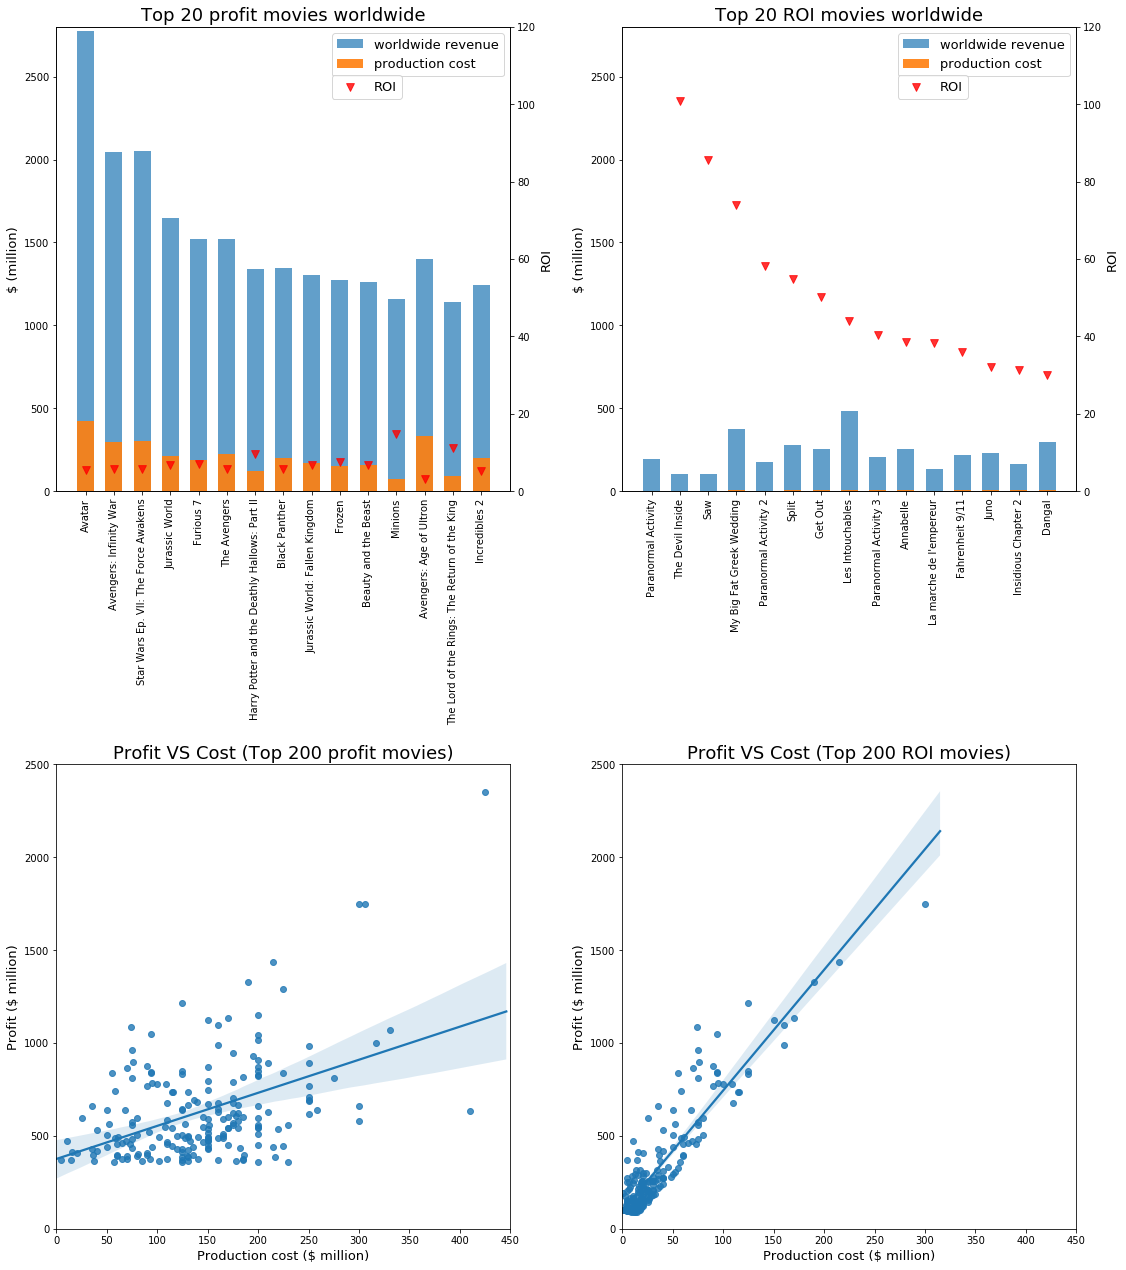

top 200 movies average production cost: 144 million


In [218]:
# use top200_profit table since it is most complete and contain all necessary information
fig = plt.figure(figsize = (16,18))


# top 15 profit movie bar plot
ax1 = fig.add_subplot(2,2,1)
x = top200_profit.head(15).movie
y_revenue = top200_profit.head(15).worldwide_gross/1000000
y_cost = top200_profit.head(15).production_budget/1000000
y_roi = top200_profit.head(15).roi


ax1.bar(x,y_revenue,width = 0.6, alpha=0.7, label = 'worldwide revenue')
ax1.bar(x,y_cost,width = 0.6, alpha=0.9, label = 'production cost')

plt.xticks(rotation=90, fontsize = 10)
plt.yticks(fontsize = 10)
ax1.set_ylabel('$ (million)', fontsize = 13)
ax1.set_ylim(0,2800)
ax1.legend(fontsize = 13)
ax1.set_title('Top 20 profit movies worldwide', fontsize = 18)

ax1_roi = ax1.twinx()
ax1_roi.scatter(x,y_roi, marker = 'v', color = 'red', alpha=0.8, s=60, label='ROI')
ax1_roi.set_ylabel('ROI', fontsize = 13)
ax1_roi.set_ylim(0,120)
ax1_roi.legend(bbox_to_anchor=(0.775, 0.91), fontsize = 13)

#top 20 ROI movie bar plot
ax2 = fig.add_subplot(2,2,2)
x = top200_roi.head(15).movie
y_revenue = top200_roi.head(15).worldwide_gross/1000000
y_cost = top200_roi.head(15).production_budget/1000000
y_roi = top200_roi.head(15).roi

ax2.bar(x,y_revenue,width = 0.6, alpha=0.7, label = 'worldwide revenue')
ax2.bar(x,y_cost,width = 0.6, alpha=0.9, label = 'production cost')
plt.xticks(rotation=90, fontsize = 10)
plt.yticks(fontsize = 10)
ax2.set_ylabel('$ (million)', fontsize = 13)
ax2.set_ylim(0,2800)
ax2.legend(fontsize = 13)
ax2.set_title('Top 20 ROI movies worldwide', fontsize = 18)

ax2_roi = ax2.twinx()
ax2_roi.scatter(x,y_roi, marker = 'v', color = 'red', alpha=0.8, s=60, label='ROI')
ax2_roi.set_ylabel('ROI', fontsize = 13)
ax2_roi.set_ylim(0,120)
ax2_roi.legend(bbox_to_anchor=(0.775, 0.91), fontsize = 13)



#top 200 profit movie scatter plot
ax3 = fig.add_subplot(2,2,3)
x = top200_profit.production_budget/1000000
y = top200_profit.profit/1000000

ax3 = sns.regplot(x=x, y=y)
ax3.set_xlabel('Production cost ($ million)', fontsize = 13)
ax3.set_ylabel('Profit ($ million)', fontsize = 13)
ax3.set_title('Profit VS Cost (Top 200 profit movies)', fontsize = 18)
ax3.set_xlim(0,450)
ax3.set_ylim(0,2500)

fig.tight_layout(pad=2.0)

#top 200 ROI movie scatter plot 
ax4 = fig.add_subplot(2,2,4)
x = top200_roi.production_budget/1000000
y = top200_roi.profit/1000000

ax4 = sns.regplot(x=x, y=y)
ax4.set_xlabel('Production cost ($ million)', fontsize = 13)
ax4.set_ylabel('Profit ($ million)', fontsize = 13)
ax4.set_title('Profit VS Cost (Top 200 ROI movies)', fontsize = 18)
ax4.set_xlim(0,450)
ax4.set_ylim(0,2500)

fig.tight_layout(pad=2.0)
plt.show()



print(f'top 200 movies average production cost: {int(top200_profit.production_budget.mean()/1000000)} million')

# Top 200 Highest Rated Movies after 2000

### Because the ratings on the RT table are inconsistent (Some show A+, some 4/5, some 7.5/10, etc), I will use the IMDB and TMDB ratings

In [60]:
#To get tmdb['imdb_id'] to line up with the imdb table, I want to remove the "tt" at the beginning of the values in the imdb_titles['tconst'] column.
imdb_titles['tconst'] = imdb_titles['tconst'].str[2:]
#Similarly, I want to make sure that tmdb['imdb_id'] has 7 digits, using 0 as a filler, so that they match
tmdb['imdb_id'] = tmdb['imdb_id'].astype(str).str.rjust(7,'0')

In [61]:
rating = imdb_titles.merge(tmdb,left_on='tconst',right_on='imdb_id')

In [62]:
#Dropping some less relevant columns
rating = rating.drop(columns=['original_title_x','original_title_y','id','genre_ids'])

In [63]:
#Dropping all movies released before the year 2000
rating['start_year'] = rating['start_year'].map(lambda x: int(x))
rating.drop(rating[rating.start_year < 2000].index)

,tconst,primary_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes,age_of_movie,dummy_key,original_language,popularity,release_date,title,vote_average,vote_count,imdb_id,title_cleaned
0,0069049,The Other Side of the Wind,2018,122.0,[Drama],[nm0000080],"[nm0000080, nm0462648]",6.9,4517,2,the_other_side_of_the_wind_2018,en,9.800,2018-11-02,The Other Side of the Wind,7.0,64,0069049,the_other_side_of_the_wind_2018
1,0249516,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",[nm0440415],"[nm0440415, nm0923312, nm0295165, nm0841854, n...",1.9,8248,8,foodfight_2012,en,4.705,2013-05-07,Foodfight!,2.1,46,0249516,foodfight_2013
2,0293069,Dark Blood,2012,86.0,[Thriller],[nm0806293],[nm0059172],6.6,1053,8,dark_blood_2012,en,1.721,2013-03-06,Dark Blood,6.1,7,0293069,dark_blood_2013
3,0315642,Wazir,2016,103.0,"[Action, Crime, Drama]",[nm2349060],"[nm7430071, nm1249226, nm0006765, nm0430785, n...",7.1,15378,4,wazir_2016,hi,3.881,2016-01-08,Wazir,6.6,63,0315642,wazir_2016
4,0323808,The Wicker Tree,2011,96.0,"[Drama, Horror]",[nm0362736],[nm0362736],3.9,2328,9,the_wicker_tree_2011,en,2.962,2012-01-27,The Wicker Tree,4.4,25,0323808,the_wicker_tree_2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9617,9206798,All Is True,2018,101.0,"[Biography, Drama, History]",[nm0000110],[nm0255780],5.9,797,2,all_is_true_2018,en,6.777,2018-12-21,All Is True,6.3,8,9206798,all_is_true_2018
9618,9275202,Breslin and Hamill: Deadline Artists,2018,108.0,[Documentary],"[nm4485929, nm1146602, nm7470181]","[nm1146602, nm0059382, nm4485929, nm3348772, n...",8.1,161,2,breslin_and_hamill_deadline_artists_2018,en,1.047,2018-11-15,Breslin and Hamill: Deadline Artists,8.0,1,9275202,breslin_and_hamill_deadline_artists_2018
9619,9282616,A Cool Fish,2018,109.0,[Comedy],[nm8824211],"[nm8824215, nm8824211]",7.1,929,2,a_cool_fish_2018,zh,2.732,2018-11-16,A Cool Fish,6.6,11,9282616,a_cool_fish_2018
9620,9316022,Struggle: The Life and Lost Art of Szukalski,2018,115.0,[Documentary],[nm2333129],"[nm3530955, nm2333129]",8.1,2018,2,struggle_the_life_and_lost_art_of_szukalski_2018,en,3.591,2018-12-21,Struggle: The Life and Lost Art of Szukalski,8.4,20,9316022,struggle_the_life_and_lost_art_of_szukalski_2018


In [64]:
rating['aggregate_score'] = round(rating.apply(lambda row: (row['averagerating'] * row['numvotes']) + (row['vote_average'] * row['vote_count']) * row['popularity'],axis=1),2)
#Creating an aggregate score: (IMDB Rating * IMDB number of votes) + (TMDB average rating * TMDB numvotes) * Popularity

In [65]:
top_200_rating = rating.sort_values(by=['aggregate_score'],ascending=False).head(200)

In [66]:
rating.sort_values(by=['aggregate_score'],ascending=False)

,tconst,primary_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes,age_of_movie,dummy_key,original_language,popularity,release_date,title,vote_average,vote_count,imdb_id,title_cleaned,aggregate_score
849,1375666,Inception,2010,148.0,"[Action, Adventure, Sci-Fi]",[nm0634240],[nm0634240],8.8,1841066,10,inception_2010,en,27.920,2010-07-16,Inception,8.3,22186,1375666,inception_2010,21342675.70
153,0848228,The Avengers,2012,143.0,"[Action, Adventure, Sci-Fi]",[nm0923736],"[nm0923736, nm0672015]",8.1,1183655,8,the_avengers_2012,en,50.289,2012-05-04,The Avengers,7.6,19673,0848228,the_avengers_2012,17106555.28
130,0816692,Interstellar,2014,169.0,"[Adventure, Drama, Sci-Fi]",[nm0634240],"[nm0634300, nm0634240]",8.6,1299334,6,interstellar_2014,en,28.440,2014-11-05,Interstellar,8.2,18597,0816692,interstellar_2014,15511241.58
7139,4154756,Avengers: Infinity War,2018,149.0,"[Action, Adventure, Sci-Fi]","[nm0751577, nm0751648]","[nm1321655, nm1321656, nm0498278, nm0456158, n...",8.5,670926,2,avengers_infinity_war_2018,en,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,4154756,avengers_infinity_war_2018,15053831.97
3206,2015381,Guardians of the Galaxy,2014,121.0,"[Action, Adventure, Comedy]",[nm0348181],"[nm3238648, nm0314153, nm0562554, nm0348181, n...",8.1,948394,6,guardians_of_the_galaxy_2014,en,49.606,2014-08-01,Guardians of the Galaxy,7.9,17958,2015381,guardians_of_the_galaxy_2014,14719505.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3305,2059179,Acting Like Adults,2012,75.0,[Drama],"[nm2394912, nm3966434]","[nm3966434, nm2394912]",7.2,10,8,acting_like_adults_2012,en,0.644,2014-03-08,Acting Like Adults,7.0,1,2059179,acting_like_adults_2014,76.51
9151,6439636,Clementina,2017,90.0,"[Drama, Horror, Mystery]",[nm1938574],"[nm4115588, nm1938574]",5.8,12,3,clementina_2017,es,0.648,2017-10-15,Clementina,8.0,1,6439636,clementina_2017,74.78
6347,3585116,The Last Man on Earth,2014,90.0,[Romance],[nm0692538],[nm0692538],7.9,7,6,the_last_man_on_earth_2014,en,0.600,2014-03-07,The Last Man on Earth,7.0,1,3585116,the_last_man_on_earth_2014,59.50
9065,6283888,The Forgotten Colours of Dreams,2018,129.0,"[Drama, Fantasy]",[nm5135243],[nm5135243],8.8,5,2,the_forgotten_colours_of_dreams_2018,en,0.699,2018-06-19,The Forgotten Colours of Dreams,8.0,2,6283888,the_forgotten_colours_of_dreams_2018,55.18


In [67]:
rating.head()

,tconst,primary_title,start_year,runtime_minutes,genres,directors,writers,averagerating,numvotes,age_of_movie,dummy_key,original_language,popularity,release_date,title,vote_average,vote_count,imdb_id,title_cleaned,aggregate_score
0,0069049,The Other Side of the Wind,2018,122.0,[Drama],[nm0000080],"[nm0000080, nm0462648]",6.9,4517,2,the_other_side_of_the_wind_2018,en,9.800,2018-11-02,The Other Side of the Wind,7.0,64,0069049,the_other_side_of_the_wind_2018,35557.70
1,0249516,Foodfight!,2012,91.0,"[Action, Animation, Comedy]",[nm0440415],"[nm0440415, nm0923312, nm0295165, nm0841854, n...",1.9,8248,8,foodfight_2012,en,4.705,2013-05-07,Foodfight!,2.1,46,0249516,foodfight_2013,16125.70
2,0293069,Dark Blood,2012,86.0,[Thriller],[nm0806293],[nm0059172],6.6,1053,8,dark_blood_2012,en,1.721,2013-03-06,Dark Blood,6.1,7,0293069,dark_blood_2013,7023.29
3,0315642,Wazir,2016,103.0,"[Action, Crime, Drama]",[nm2349060],"[nm7430071, nm1249226, nm0006765, nm0430785, n...",7.1,15378,4,wazir_2016,hi,3.881,2016-01-08,Wazir,6.6,63,0315642,wazir_2016,110797.52
4,0323808,The Wicker Tree,2011,96.0,"[Drama, Horror]",[nm0362736],[nm0362736],3.9,2328,9,the_wicker_tree_2011,en,2.962,2012-01-27,The Wicker Tree,4.4,25,0323808,the_wicker_tree_2012,9405.02


In [ ]:
#Plot top 10 highest rated movies with bar chart
#Top 100 movies, how they are distributed by popularity vs average rating scatter plot
# Research other forms of categorical visualizations
# Most common genre top 200
# Top 3 directors for rating